In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import time
from collections import Counter
from wordcloud import WordCloud
from matplotlib.font_manager import FontProperties

import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim

In [3]:
# !pip install -q pythainlp
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords

from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
import torch

In [7]:
df = pd.read_csv('JS100_tweets.csv')
# df.drop(columns='Time', inplace=True)
print(df.shape)
df.head()

(926, 1)


,Tweet
0,ไปเที่ยวกับพี่ไม่มีอ่อม! กลับมาครั้งยิ่งใหญ่ ...
1,20:17 #อุบัติเหตุ #ถนนมอเตอร์เวย์ ช่วง ด่านเก็...
2,19:53 #ถนนรัชดาท่าพระ ช่วง แยกรัชดาตลาดพลู >แย...
3,18:58 #อุบัติเหตุ #ถนนกาญจนาภิเษก ช่วง ต่างระด...
4,18:55 #อุบัติเหตุ #ถนนมอเตอร์เวย์ (ช่วง แยกพัท...


In [8]:
def filter_accident_tweet(df):
  accident_idx = []
  for i, tweet in enumerate(df['Tweet']):
    if 'เหตุ' in tweet:
      accident_idx.append(i)

  return df.loc[accident_idx].reset_index(drop=True)


filtered_df = filter_accident_tweet(df)

## EDA

1. Top 10 hashtag

In [9]:
def extract_location_and_incident(text):
    words = text.split()
    hashtags = [word for word in words if word.startswith('#')]
    return hashtags

all_hashtags = df['Tweet'].apply(extract_location_and_incident).sum()
hashtag_frequency = Counter(all_hashtags)
hashtag_frequency = pd.DataFrame(hashtag_frequency.items(), columns=['Hashtag', 'Frequency'])\
                          .sort_values(by='Frequency', ascending=False)

hashtag_frequency.head(10)

,Hashtag,Frequency
3,#รถติด,340
1,#อุบัติเหตุ,281
15,#ข่าวPNC,77
13,#JS100,52
18,#ฝนตก,29
5,#ถนนกาญจนาภิเษก,28
23,#ถนนพหลโยธิน,25
31,#ถนนพระราม2,23
9,#ถนนจรัญสนิทวงศ์,16
2,#ถนนมอเตอร์เวย์,15


2. WordCloud

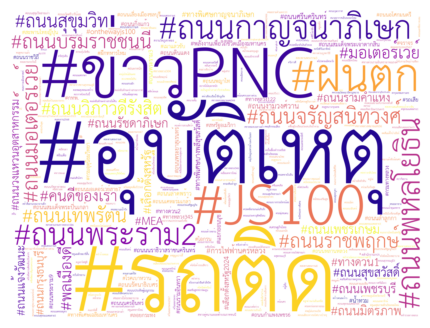

In [11]:
hashtag_freq_dict = hashtag_frequency.set_index('Hashtag')['Frequency'].to_dict()
wordcloud = WordCloud(
                      font_path='THSarabunNew.ttf',
                      relative_scaling = 0.3,
                      min_font_size=1,
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=2000,
                      colormap='plasma',
                      scale=3,
                      font_step=4,
                      collocations=False,
                      regexp=r"[ก-๙a-zA-Z']+",
                      margin=2
                      ).generate_from_frequencies(hashtag_freq_dict)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

3. Bar Chart

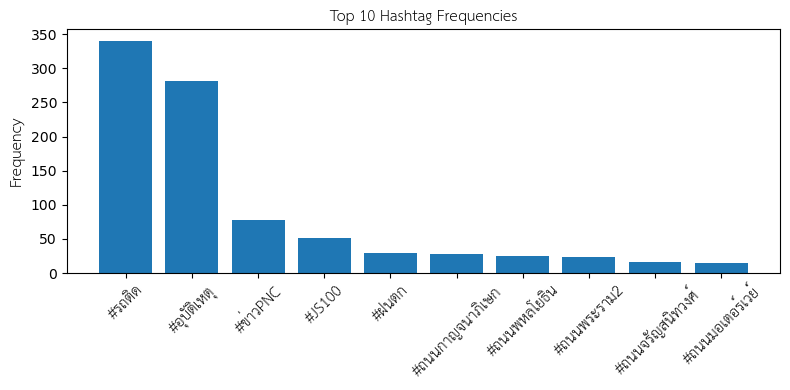

In [12]:
top10_hashtag = hashtag_frequency.sort_values(by='Frequency', ascending=False).head(10)
font_prop = FontProperties(fname='THSarabunNew.ttf', size=16)

plt.figure(figsize=(8, 4))
plt.bar(top10_hashtag['Hashtag'], top10_hashtag['Frequency'])
plt.xticks(rotation=45, fontproperties=font_prop)  # Rotate x-axis labels
plt.ylabel('Frequency', fontproperties=font_prop)
plt.title('Top 10 Hashtag Frequencies', fontproperties=font_prop)
plt.tight_layout()
plt.show()

## Preprocessing

### 1. Hashtag tweet
- filter by hashtag order

In [13]:
location, start, end = [], {}, {}

# extract the area of incident if sentence has pattern <start> > <end>
def extract_location(words):
  for ind, word in enumerate(words):
      if word.startswith('>'):
        # print(f'start: {words[ind - 1]}  end: {word.replace(">", "")}')
        start[i] = words[ind - 1]
        end[i] = word.replace('>', '')
        break

In [14]:
for i, text in enumerate(filtered_df['Tweet']):
  words = text.split()

  hashtag = [word for word in words if word.startswith('#')]

  if '#อุบัติเหตุ' in hashtag:
    try:
      # print(f'location {i}: {hashtag[1]}')
      location.append(hashtag[1].replace('#', ''))
    except:
      filtered_df.drop(index=i, inplace=True)
  filtered_df.reset_index(drop=True, inplace=True)

  extract_location(words)

In [15]:
hashtag_df = pd.DataFrame(columns=['location', 'start', 'end'])
hashtag_df['location'] = location
hashtag_df['start'] = start
hashtag_df['end'] = end
hashtag_df.fillna('-', inplace=True)

hashtag_df.sample(10)

,location,start,end
73,ถนนมอเตอร์เวย์,ต่างระดับเพชรเกษม,
223,ถนนรัชดาภิเษก,ถ.รามอินทรา,ถ.ปัญญา-รามอินทรา
0,ถนนมอเตอร์เวย์,ด่านเก็บเงินบางบ่อ,ด่านเก็บเงินลาดกระบัง
12,ถนนหทัยราษฎร์,ถ.กาญจนาภิเษก,คลองพระยาสุเรนทร์
224,ถนนพหลโยธิน,สามแยกลำลูกกา,ฐานทัพอากาศ
195,ถนนเพชรเกษม,-,-
25,ซอยรามอินทรา8,ช่วงแยกแกลง,แยกทางเกวียน
109,ทางคู่ขนานลอยฟ้าบรมราชชนนี,-,-
190,ทางหลวง122,วัดเสมียนนารี,ที่บริเวณหน้าหมู่บ้านกลางเมือง
51,ถนนกาญจนาภิเษก,-,-


### 2. Non-Hashtag tweet

**Approach 1:** filter from regex (hard-coding)

In [16]:
def extract_location_regex(tweet):
    location_pattern = r"(ถนน\s?[^\s,]*)|(แยก\s?[^\s,]*)|(สะพาน\s?[^\s,]*)|(ซอย\s?[^\s,]*)|(ทางหลวง\s?[^\s,]*)"
    matches = re.findall(location_pattern, tweet)

    locations = []
    for match in matches:
        for loc in match:
            if loc:
                if loc.endswith(")") and "(" not in loc[:-1]:
                    loc = loc[:-1]  # Remove ')' if it's at the end but not part of the word
                locations.append(loc)
    return ", ".join(locations)


df['Tweet'].apply(extract_location_regex).sample(10)

919          ถนนเพชรบุรี, สะพานข้ามแยกยมราช, แยกอุรุพงษ์
60                                                      
659                                                     
846                                                     
722                                                     
789                   ทางหลวง304, สะพานหน้าวัดเขาหินซ้อน
130    สะพานวงแหวนอุตสาหกรรมการจราจรหลังจากฝนตกก็เคลื...
159                                                     
840                                                     
417                                          ถนนสารีบุตร
Name: Tweet, dtype: object

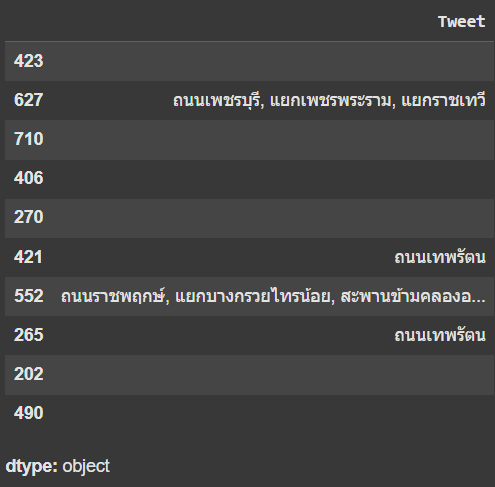

**Approach 2:** use thaiNER from pyThaiNLP package

In [17]:
def clean_text(text):
  text = re.compile(r'[/(){}\[\]\|@,;#+_\n]|น\.').sub('', text)
  text = text.replace('jsradio', '')

  return text

In [18]:
idx = [i for i, tweet in enumerate(filtered_df['Tweet']) if '#' in tweet]
th_stopwords = thai_stopwords()

no_hashtag_df = filtered_df.drop(index=idx)
no_hashtag_df['Tweet'] = no_hashtag_df['Tweet'].apply(clean_text)
no_hashtag_df.reset_index(drop=True, inplace=True)

In [19]:
name="pythainlp/thainer-corpus-v2-base-model"
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForTokenClassification.from_pretrained(name)

In [20]:
def fix_span_error(words,ner):
    _ner = []
    _ner = ner
    _new_tag = []
    for i, j in zip(words,_ner):
        #print(i,j)
        i = tokenizer.decode(i)
        if i.isspace() and j.startswith("B-"):
            j = "O"
        if i == '' or i == '<s>' or i == '</s>':
            continue
        if i == "<_>":
            i = " "
        _new_tag.append((i,j))
    return _new_tag

def extract_ner(sentence):
    # Tokenization
    cut = word_tokenize(sentence.replace(" ", "<_>"))
    inputs = tokenizer(cut, is_split_into_words=True, return_tensors="pt")

    # fit into model
    ids = inputs["input_ids"]
    mask = inputs["attention_mask"]
    outputs = model(ids, attention_mask=mask)  # forward pass

    predictions = torch.argmax(outputs[0], dim=2)
    predicted_token_class = [model.config.id2label[t.item()] for t in predictions[0]]

    ner = fix_span_error(inputs['input_ids'][0], predicted_token_class)

    # filter the LOCATION
    ner_list = [word if 'LOCATION' in tag else ' ' for word, tag in ner]

    return ''.join(ner_list).strip()

In [21]:
no_hashtag_df['candidates_loc'] = no_hashtag_df['Tweet'].apply(extract_ner)
no_hashtag_df['candidates_loc'] = no_hashtag_df['candidates_loc'].apply(lambda x: x.split())

In [22]:
def filter_location(loc):
  # remove one character in list e.g. 'ม'
  loc = [x for x in loc if len(x) > 3 or x.isnumeric() or x == 'สาย' or x == 'แยก']

  for i, word in enumerate(loc):
    if word.isnumeric() and i != 0:
      return ''.join(loc[:i+1])
      break
    elif word.isnumeric() and i == 0:
      loc.remove(word)
      continue
    elif 'ถนน' in word or 'ถ.' in word:
      return word

  return loc[0]


no_hashtag_df['location'] = no_hashtag_df['candidates_loc'].apply(filter_location)

## Text classification model for accident case

In [23]:
def clean_ner_word(df):
  for i, tweet in enumerate(df['Tweet']):
    for word in df.loc[i, 'candidates_loc']:
      tweet = tweet.replace(word, '')

    df.loc[i, 'Tweet'] = tweet

  df['Tweet'] = df['Tweet'].apply(lambda x: re.compile(r'[0-9]').sub('', x))

In [24]:
accident_idx = df[ (df['Tweet'].str.contains('รถติด|อุบัติเหตุ')) ].index

# Data preparation
train_df = df.copy()
train_df['Accident'] = 0
train_df.loc[accident_idx, 'Accident'] = 1

# Preprocessing
train_df['candidates_loc'] = train_df['Tweet'].apply(extract_ner)
train_df['candidates_loc'] = train_df['candidates_loc'].apply(lambda x: x.split())
clean_ner_word(train_df)

**Training Model**

In [25]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [26]:
pd.crosstab(train_df['Accident'], 'count')

col_0,count
Accident,
0,456
1,470


In [27]:
# Prepare the data for training
X = train_df['Tweet'].values
y = train_df['Accident'].values

# Data Preparation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Building model
model = Sequential()
model.add(Embedding(2000, 64, input_length=max_sequence_length))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Training model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/10


c:\Users\folks\miniconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7534 - loss: 0.6567 - val_accuracy: 0.9301 - val_loss: 0.4469
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9158 - loss: 0.3913 - val_accuracy: 0.9301 - val_loss: 0.2214
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9118 - loss: 0.2262 - val_accuracy: 0.9409 - val_loss: 0.1798
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9424 - loss: 0.1637 - val_accuracy: 0.9409 - val_loss: 0.1621
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9429 - loss: 0.1340 - val_accuracy: 0.9462 - val_loss: 0.1475
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9689 - loss: 0.0980 - val_accuracy: 0.9409 - val_loss: 0.1432
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9657 - loss: 0.1007 - val_accuracy: 0.9409 - val_loss: 0.1336
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9754 - loss: 0.0811 - val_accuracy: 0.9409 - val_loss: 0.

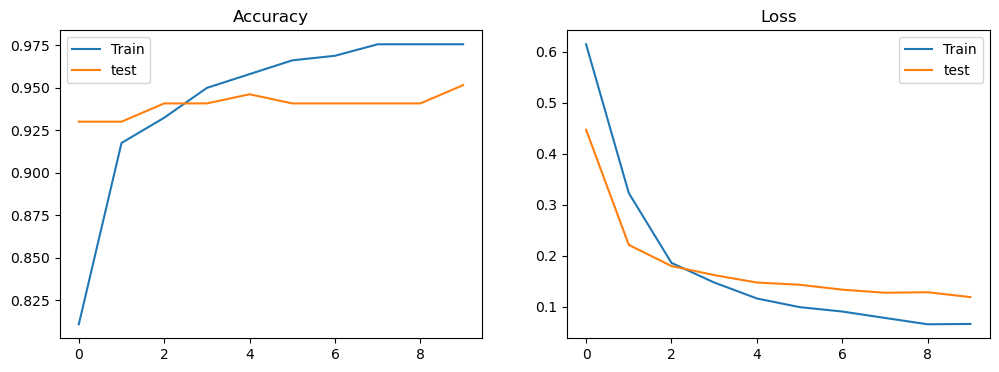

In [28]:
plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [29]:
predictions = model.predict(X_test_pad)
predictions = (predictions > 0.5).astype('int')

result = pd.DataFrame({'Tweet': X_test, 'Accident': predictions.flatten()})
result.sample(10)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


,Tweet,Accident
135,ผนึกกำลังเครือข่าย ยกระดับการดูแลสุขภาพจิตแล...,0
126,MEA ร่วมกับสำนักงานเขตพระนคร ประดับไฟต้อนรับเท...,0
28,: น้ำทะเลหนุน # ขาออก ใต้สะพานกลับรถคลองตาขำ ก...,1
6,สธ.รณรงค์วันเบาหวานโลก ชี้คนไทยป่วย . ล้านคน ย...,0
102,":น. # ช่วง > , บริเวณบน รถเก๋ง คัน ชนกัน ...",1
21,@jsradio\n . น. มุ่งหน้า รถติดยาวเลยไปอีกค่ะ,0
165,: #อุบัติเหตุ # ขาออก >ที่บริเวณโค้งก่อนถึง ...,1
117,RT\n@SpdcommandP\n ลานจอดรถ Paragon เต็มทุกชั้...,1
95,#กทพ. แจ้งปิดเบี่ยงการจราจร #ทางพิเศษเฉลิมมหาน...,0
128,: #อุบัติเหตุ # ขาเข้า จาก >ที่บริเวณในอุโมงค...,1


Test with real tweet

In [30]:
seq_prep = tokenizer.texts_to_sequences(no_hashtag_df['Tweet'])
pad_prep = pad_sequences(seq_prep, maxlen=max_sequence_length)

pred = model.predict(pad_prep)
pred = (pred > 0.5).astype('int').flatten()
result = pd.DataFrame({'Predictions': pred.flatten()})
no_hashtag_df = pd.concat([no_hashtag_df, result], axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


## Map to geographical
interactive map: https://medium.com/@witchapongdaroontham/interactive-map-plot-with-bokeh-4afa77ad42c1

In [31]:
filter = (no_hashtag_df['Predictions'] == 1)
location = pd.concat([hashtag_df['location'], no_hashtag_df.loc[filter, 'location']], axis=0)
location_df = pd.DataFrame(location, columns=['location'])

In [32]:
geolocator = Nominatim(user_agent="location_mapper")
location_cache = {}

def get_coordinates(location_text, retries=3):
    # Check cache first
    if location_text in location_cache:
        return location_cache[location_text]

    for attempt in range(retries):
        try:
            location = geolocator.geocode(location_text)
            if location:
                coordinates = (location.latitude, location.longitude)
            else:
                coordinates = (None, None)
            # Cache and return
            location_cache[location_text] = coordinates
            return coordinates
        except Exception as e:
            print(f"Error: {e} - Retrying ({attempt+1}/{retries})")
            time.sleep(0.2)  # Shorter delay for retry
    return None, None  # Return None after retries exhausted


for i, loc in enumerate(location_df['location']):
  location_df.loc[i, 'Latitude'], location_df.loc[i, 'Longitude'] = get_coordinates(loc)

In [33]:
location_df.dropna(subset=['Latitude', 'Longitude'], inplace=True)

Top 10 accident location

In [34]:
pd.crosstab(location_df['location'], columns='N').sort_values(ascending=False, by='N').head(10)

col_0,N
location,
ถนนกาญจนาภิเษก,19
ถนนพหลโยธิน,14
ถนนเทพรัตน,12
ถนนจรัญสนิทวงศ์,11
ถนนพระราม2,11
ถนนมอเตอร์เวย์,11
ถนนบรมราชชนนี,10
ถนนราชพฤกษ์,8
ถนนสุขุมวิท,8


## Display on map

In [35]:
# center lat and long of Bangkok
center_lat, center_long = 13.75, 100.5

# Initialize the map
map = folium.Map(location=[center_lat, center_long], zoom_start=12)

# Prepare heatmap data
heatmap_data = [ [row['Latitude'], row['Longitude']] for index, row in location_df.iterrows() ]
HeatMap(heatmap_data).add_to(map)

map.save("heatmap.html")
map